In [105]:
# Как я это сделала: 
# 1) дата транзакции
# 2) дата регистрации
# 3) соединение 1 b 2
# 4) оставление only важное
# 5) Cколько было всего вначале в каждой когорте людей 
# 6) Справа колонка retention (делим количество в конкретном месяце на то, сколько было) 
# 7) Pivot 

## Всегда будет дата транзакции, из которой мы узнаем дату регистрации для индексов и lifetime для колонок (месяц/неделя)

In [89]:
# Дата пользования - преобразование 
import pandas as pd

df=pd.read_csv('Customer_Subscription_And_Transaction_Details.csv')
df.head(10)

,cust_id,transaction_type,transaction_date,subscription_type,subscription_price,customer_gender,age_group,customer_country,referral_type
0,1,initial,2020-09-01,BASIC,33,Male,35-44,Denmark,Google Ads
1,2,initial,2022-03-01,BASIC,53,Female,18-24,Denmark,facebook
2,3,initial,2020-10-01,MAX,99,Female,25-34,Norway,facebook
3,3,REDUCTION,2022-02-01,BASIC,53,Female,25-34,Norway,facebook
4,4,initial,2022-05-01,PRO,85,Male,18-24,Sweden,Display
5,5,initial,2022-08-01,BASIC,53,Male,35-44,Sweden,Google Ads
6,6,initial,2022-06-01,MAX,119,Male,55-65,Sweden,facebook
7,7,initial,2022-02-01,MAX,119,Female,25-34,Sweden,facebook
8,8,initial,2021-01-01,BASIC,43,Other,45-54,Sweden,facebook
9,8,CHURN,2021-04-01,BASIC,43,Other,45-54,Sweden,facebook


In [90]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_date'].sort_values()
# df = df[df['timePeriod'].dt.year

9582    2020-01-01
16206   2020-01-01
6849    2020-01-01
16250   2020-01-01
949     2020-01-01
           ...    
1274    2022-12-01
8506    2022-12-01
850     2022-12-01
4884    2022-12-01
3386    2022-12-01
Name: transaction_date, Length: 18106, dtype: datetime64[ns]

In [91]:
df = df[(df['transaction_date'] > '2021-01-01') & (df['transaction_date'] < '2021-12-31')]


In [92]:
df['transaction_date'] = pd.to_datetime(df['transaction_date']).dt.month
# df['timePeriod_of_using'] = [int(i) + 1 for i in df['timePeriod'].dt.strftime('%W')]
# df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%Y-%m-%d')
df

,cust_id,transaction_type,transaction_date,subscription_type,subscription_price,customer_gender,age_group,customer_country,referral_type
9,8,CHURN,4,BASIC,43,Other,45-54,Sweden,facebook
11,9,CHURN,3,BASIC,43,Female,25-34,Sweden,facebook
23,17,initial,12,BASIC,43,Male,45-54,Denmark,Unknown
25,18,initial,11,BASIC,43,Female,35-44,Denmark,Bing
29,21,initial,9,PRO,75,Other,55-65,Sweden,Organic Search
...,...,...,...,...,...,...,...,...,...
18089,10357,REDUCTION,3,BASIC,43,Male,25-34,Sweden,Paid Search
18098,10363,REDUCTION,7,BASIC,43,Female,18-24,Finland,Google Ads
18100,10364,initial,4,PRO,75,Female,45-54,Norway,facebook
18102,10365,initial,5,PRO,75,Male,55-65,Norway,Google Ads


## Всегда будет дата регистрации

In [93]:
# Дата регистрации
users = df.groupby(by='cust_id')['transaction_date'].min().reset_index()
users = users.rename(columns={'transaction_date':'tran_time_min'}) 
users

,cust_id,tran_time_min
0,8,4
1,9,3
2,17,12
3,18,11
4,21,9
...,...,...
4943,10353,4
4944,10357,3
4945,10363,7
4946,10364,4


## Мы всегда будем мержить таблицу с датой пользования с датой регистрации по id user'а

In [94]:
# Мержим дату пользования с датой регистрации 

df = df.merge(users, how='left', on='cust_id')

In [104]:
df['cohort_lifetime'] = df['transaction_date'] - df['tran_time_min']
df

,cust_id,transaction_type,transaction_date,subscription_type,subscription_price,customer_gender,age_group,customer_country,referral_type,tran_time_min,cohort_lifetime
0,8,CHURN,4,BASIC,43,Other,45-54,Sweden,facebook,4,0
1,9,CHURN,3,BASIC,43,Female,25-34,Sweden,facebook,3,0
2,17,initial,12,BASIC,43,Male,45-54,Denmark,Unknown,12,0
3,18,initial,11,BASIC,43,Female,35-44,Denmark,Bing,11,0
4,21,initial,9,PRO,75,Other,55-65,Sweden,Organic Search,9,0
...,...,...,...,...,...,...,...,...,...,...,...
5862,10357,REDUCTION,3,BASIC,43,Male,25-34,Sweden,Paid Search,3,0
5863,10363,REDUCTION,7,BASIC,43,Female,18-24,Finland,Google Ads,7,0
5864,10364,initial,4,PRO,75,Female,45-54,Norway,facebook,4,0
5865,10365,initial,5,PRO,75,Male,55-65,Norway,Google Ads,5,0


## Мы всегда будем оставлять в таблице только важное

In [96]:
cohorts = df.pivot_table(index = ['tran_time_min', 'cohort_lifetime'],
                         aggfunc = {'cust_id':'nunique'}).reset_index()


In [97]:
cohorts

,tran_time_min,cohort_lifetime,cust_id
0,2,0,477
1,2,1,12
2,2,2,5
3,2,3,20
4,2,4,12
...,...,...,...
61,10,1,9
62,10,2,4
63,11,0,440
64,11,1,10


## Мы всегда будем искать, сколько было всего 

In [98]:
# Узнаем initial number of people in each cohort

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0]
initial_users_count = initial_users_count[['tran_time_min','cust_id']]
initial_users_count = initial_users_count.rename(columns={'cust_id':'cohort_users'}) 
initial_users_count

,tran_time_min,cohort_users
0,2,477
11,3,448
21,4,466
30,5,503
38,6,483
45,7,429
51,8,440
56,9,422
60,10,439
63,11,440


In [99]:
cohorts = cohorts.merge(initial_users_count,on='tran_time_min')

## Мы всегда будем делать колонку с retention

In [100]:
cohorts['retention'] = cohorts['cust_id']/cohorts['cohort_users'] 
cohorts

,tran_time_min,cohort_lifetime,cust_id,cohort_users,retention
0,2,0,477,477,1.000000
1,2,1,12,477,0.025157
2,2,2,5,477,0.010482
3,2,3,20,477,0.041929
4,2,4,12,477,0.025157
...,...,...,...,...,...
61,10,1,9,439,0.020501
62,10,2,4,439,0.009112
63,11,0,440,440,1.000000
64,11,1,10,440,0.022727


In [101]:
retention_pivot = cohorts.pivot_table(index='tran_time_min',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum') 

In [102]:
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10
tran_time_min,,,,,,,,,,,
2,1.0,0.025157,0.010482,0.041929,0.025157,0.050314,0.031447,0.050314,0.044025,0.046122,0.048218
3,1.0,0.011161,0.015625,0.040179,0.051339,0.046875,0.051339,0.046875,0.049107,0.051339,NaN
4,1.0,0.021459,0.019313,0.042918,0.055794,0.045064,0.038627,0.040773,0.049356,NaN,NaN
5,1.0,0.027833,0.013917,0.055666,0.043738,0.035785,0.045726,0.035785,NaN,NaN,NaN
6,1.0,0.004141,0.020704,0.047619,0.035197,0.041408,0.043478,NaN,NaN,NaN,NaN
7,1.0,0.018648,0.013986,0.037296,0.037296,0.072261,NaN,NaN,NaN,NaN,NaN
8,1.0,0.018182,0.034091,0.027273,0.047727,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.023697,0.007109,0.040284,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1.0,0.020501,0.009112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


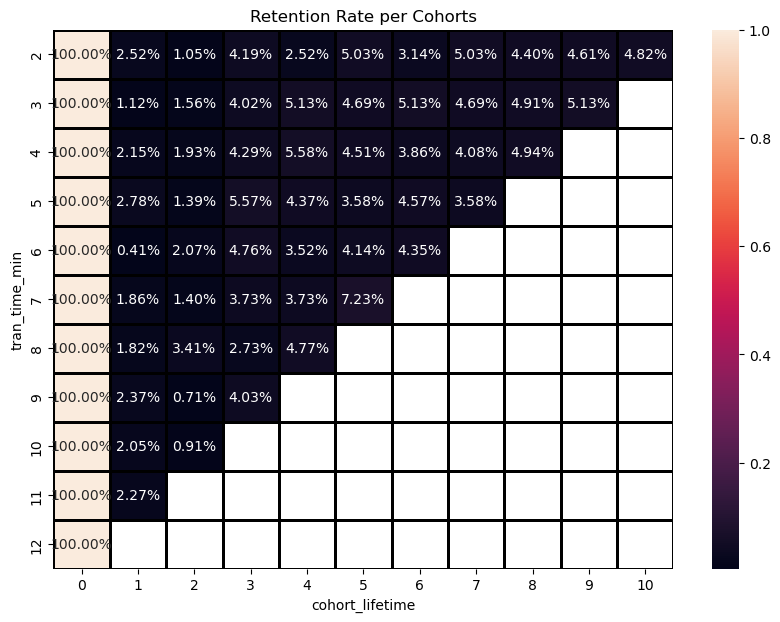

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
plt.title('Retention Rate per Cohorts')
sns.heatmap(retention_pivot.iloc[:, :], annot=True, 
            fmt='.2%', linewidths=1, linecolor='black'); 